# About
Roughwork exploration GameStop Stock return data:
1. Power law fit
2. Normal distribution fit

In [1]:
import pandas as pd

import fattails.metrics as fattails

# Setup

##### Load Data

In [2]:
data_source = 'https://query1.finance.yahoo.com/v7/finance/download/GME?period1=1013558400&period2=1611878400&interval=1d&events=history&includeAdjustedClose=true'

price_data = pd.read_csv(data_source)
price_data = price_data.set_index('Date')
price_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-02-13,9.625,10.060,9.525,10.050,6.766666,19054000
2002-02-14,10.175,10.195,9.925,10.000,6.733003,2755400
2002-02-15,10.000,10.025,9.850,9.950,6.699336,2097400
2002-02-19,9.900,9.900,9.375,9.550,6.430017,1852600
2002-02-20,9.600,9.875,9.525,9.875,6.648838,1723200


##### Calculate Returns

In [3]:
close_price = price_data.Close
previous_close_price = price_data.Close

daily_return = close_price / previous_close_price.shift(1) - 1

# Format as a DataFrame
df = daily_return.to_frame('daily_return') 
df

,daily_return
Date,
2002-02-13,NaN
2002-02-14,-0.004975
2002-02-15,-0.005000
2002-02-19,-0.040201
2002-02-20,0.034031
...,...
2021-01-22,0.510806
2021-01-25,0.181203
2021-01-26,0.927074


In [4]:
# Remove NaN value
assert df.daily_return.isna().sum() == 1 # The first day has no prior day so return is NaN
df.dropna(inplace=True)

# 2. Check for Power Law
Check the right tail for Power Law behaviour.

Power laws are straight on loglog plots. We'll plot the empirical right tail and check for this behaviour.

In [5]:
# Calculate survival probability for each datapoint
df['survival_probability'] = fattails.get_survival_probability(df.daily_return)
df = df.sort_values(by='daily_return') # show sorted values
df

,daily_return,survival_probability
Date,,
2021-01-28,-0.442894,0.999790
2019-06-05,-0.355499,0.999581
2002-12-19,-0.300300,0.999371
2019-01-29,-0.272258,0.999162
2014-01-14,-0.198808,0.998952
...,...,...
2020-10-08,0.441239,0.001048
2021-01-22,0.510806,0.000838
2021-01-13,0.573935,0.000629


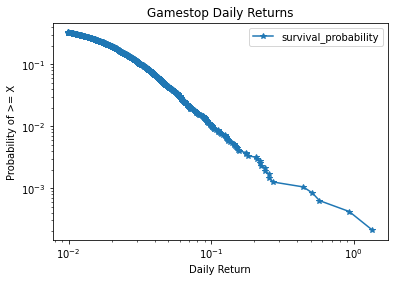

In [6]:
# Plot the Right Tail
selection = df.survival_probability < 0.33 # select top 33% of datapoints
ax = df.loc[selection].plot(x='daily_return', y='survival_probability', loglog=True, marker='*', title='Gamestop Daily Returns')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Probability of >= X');

### Conclusions
If we assume that the tail is power law distributed, then the crazy moves of Gamestop stock in 2021 are not outliers! 

# 2. Fit a Normal Distribution

In [7]:
import numpy as np
from scipy.stats import norm

In [8]:
def fit_gaussian_pdf(mean, std):
    
    x = np.linspace(mean-4*std, mean+4*std, 100)                   # 100 equally spaced x locations
    y = norm.pdf(x, loc=mean, scale=std) # 100 corresponding probability densities

    return x,y

In [9]:
# Get Mean and Standard Deviation from Dataset
norm_params = ['50%', 'mean', 'std']
norm_params = df.daily_return.describe().loc[norm_params]

mean=norm_params.loc['mean']
std = norm_params.loc['std']

norm_params.to_frame()

,daily_return
50%,0.000379
mean,0.001414
std,0.042956


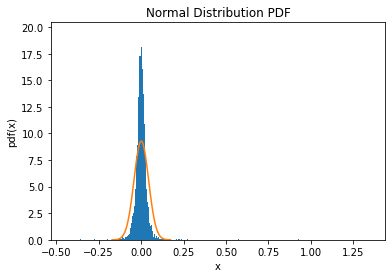

In [10]:
x, y = fit_gaussian_pdf(mean,std)

# Plot Histogram
normalization_kwargs = {'stacked':True, 'density':True}
ax = df.daily_return.plot(kind='hist', **normalization_kwargs, bins=500)

ax.plot(x, y)
ax.set(xlabel='x', ylabel='pdf(x)',
       title='Normal Distribution PDF');

### Final Conclusion
* If we assume a **normal distribution** the fit is not very good. We made a plot to compare the empirical data against a normal distribution of the same mean and variance. The high peak and low shoulders of the empirical data are typical for fat tailed data. Of course we even see outliers many sigma into the tails, which is almost never happens with a true normal distribution.
* If we assume that the tail is **power law** distributed, then the crazy moves of Gamestop stock in 2021 are not outliers! 